In [221]:
from qiskit_aer import AerSimulator
from qiskit import * 
from qiskit.visualization import * 
import matplotlib.pyplot as plt
from collections import Counter
import random
from qiskit_aer.noise import NoiseModel, depolarizing_error, pauli_error

In [222]:
sim = Aer.get_backend('aer_simulator')
shots = 1024

In [223]:
# Функція для підрахунку частот по кубітах
def calculate_frequencies(counts_dict, n_qubits, total_shots):
    freqs_per_qubit = [{'0':0, '1':0} for _ in range(n_qubits)]
    total_zeros = 0
    total_ones = 0
    
    for bitstring, count in counts_dict.items():
        for i, bit in enumerate(bitstring):
            freqs_per_qubit[i][bit] += count
            if bit == '0':
                total_zeros += count
            else:
                total_ones += count

    print("\nЗагальні частоти всіх бітів:")
    total_bits = total_zeros + total_ones
    print(f"0: {total_zeros} ({total_zeros/total_bits*100:.2f}%), "
          f"1: {total_ones} ({total_ones/total_bits*100:.2f}%)")
    
    print("\nЧастоти по кубітах:")
    for i, f in enumerate(freqs_per_qubit):
        print(f"Кубіт {i}: 0 = {f['0']/total_shots*100:.2f}%, "
              f"1 = {f['1']/total_shots*100:.2f}%")
    return freqs_per_qubit, (total_zeros, total_ones)

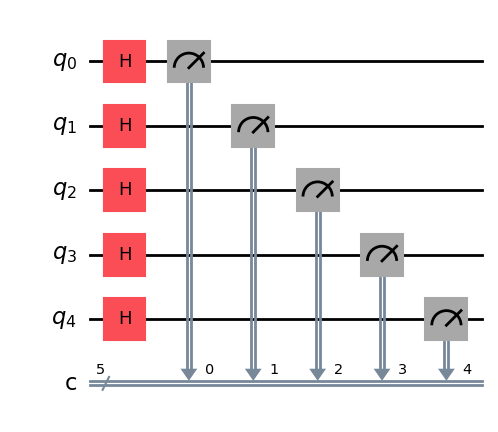

In [224]:
# Підготовка квантової схеми
n = 5  # Кількість кубітів
qc = QuantumCircuit(n, n)

# Наносимо H-гейт на кожен кубіт (створюємо суперпозицію)
for i in range(n):
    qc.h(i)

# Вимірювання кубітів
qc.measure(range(n), range(n))

# Візуалізація схеми
qc.draw('mpl')


=== Без шуму ===
Результати вимірювань: {'01001': 35, '10000': 42, '00001': 30, '00101': 33, '00111': 36, '10110': 35, '01100': 33, '11110': 30, '10010': 24, '01011': 32, '00100': 22, '00110': 39, '11001': 30, '10001': 41, '10101': 42, '11111': 40, '10111': 30, '01010': 30, '00000': 30, '11101': 31, '01101': 32, '01000': 26, '01110': 30, '11000': 37, '11100': 33, '10100': 35, '00011': 30, '00010': 30, '01111': 28, '10011': 24, '11010': 32, '11011': 22}

Загальні частоти всіх бітів:
0: 2554 (49.88%), 1: 2566 (50.12%)

Частоти по кубітах:
Кубіт 0: 0 = 48.44%, 1 = 51.56%
Кубіт 1: 0 = 51.07%, 1 = 48.93%
Кубіт 2: 0 = 48.34%, 1 = 51.66%
Кубіт 3: 0 = 51.95%, 1 = 48.05%
Кубіт 4: 0 = 49.61%, 1 = 50.39%


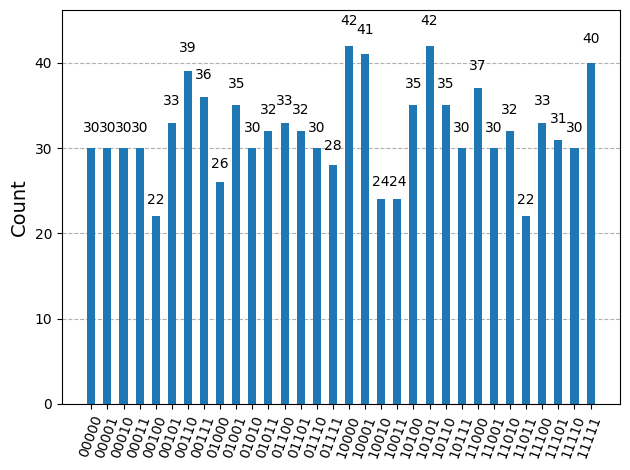

In [225]:
#  Виконання без шуму
qc_no_noise = transpile(qc, sim)
result = sim.run(qc_no_noise, shots=shots).result()
counts_no_noise = result.get_counts()
print("\n=== Без шуму ===")
print("Результати вимірювань:", counts_no_noise)
calculate_frequencies(counts_no_noise, n, shots)
plot_histogram(counts_no_noise)

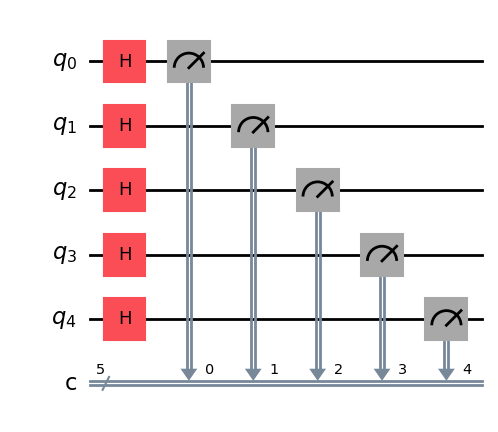

In [226]:
# Створюємо шумову модель
noise_model = NoiseModel()
error = depolarizing_error(0.05, 1)
noise_model.add_all_qubit_quantum_error(error, ['h'])

qc_noisy = transpile(qc, sim)
qc_noisy.draw('mpl')


=== З шумом ===
Результати вимірювань: {'00000': 35, '01000': 37, '11001': 28, '11011': 31, '01100': 29, '00100': 37, '11000': 32, '01011': 32, '00111': 36, '10101': 31, '00110': 32, '01110': 30, '10100': 37, '10001': 34, '00011': 33, '11111': 26, '10110': 25, '00010': 29, '01001': 27, '11100': 35, '11010': 27, '01010': 28, '00001': 49, '01111': 32, '01101': 36, '00101': 45, '10000': 24, '10010': 38, '11101': 32, '10011': 24, '11110': 26, '10111': 27}

Загальні частоти всіх бітів:
0: 2640 (51.56%), 1: 2480 (48.44%)

Частоти по кубітах:
Кубіт 0: 0 = 53.42%, 1 = 46.58%
Кубіт 1: 0 = 52.34%, 1 = 47.66%
Кубіт 2: 0 = 49.61%, 1 = 50.39%
Кубіт 3: 0 = 53.52%, 1 = 46.48%
Кубіт 4: 0 = 48.93%, 1 = 51.07%


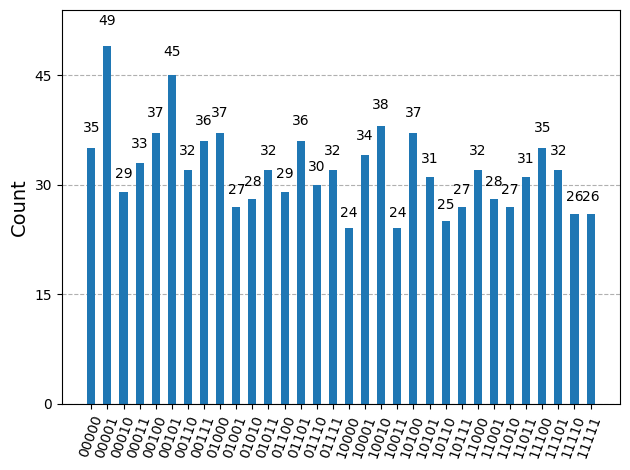

In [227]:
result_noisy = sim.run(qc_noisy, shots=shots, noise_model=noise_model).result()
counts_noisy = result_noisy.get_counts()
qc_noisy.draw('mpl')
print("\n=== З шумом ===")
print("Результати вимірювань:", counts_noisy)
calculate_frequencies(counts_noisy, n, shots)
plot_histogram(counts_noisy)


=== ПІСЛЯ КОРЕКЦІЇ ФОН НЕЙМАНА ===
Результати вимірювань: {'0': 493, '1': 522}
0: 493 (48.57%), 1: 522 (51.43%)


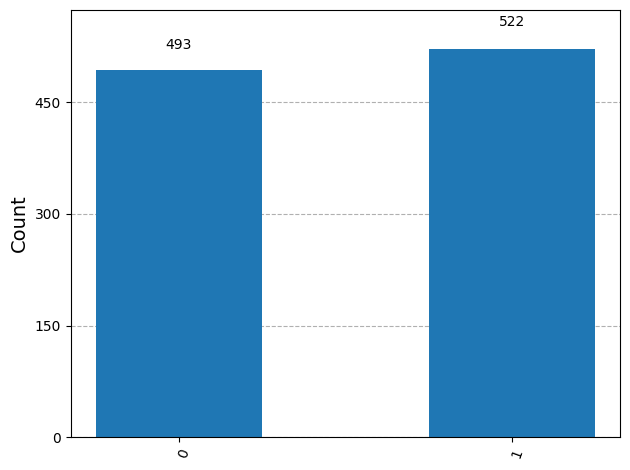

In [228]:
def von_neumann_extractor(bitstrings):
    extracted = ''
    for bitstring in bitstrings:
        for i in range(0, len(bitstring) - 1, 2):
            pair = bitstring[i:i+2]
            if pair == '01':
                extracted += '0'
            elif pair == '10':
                extracted += '1'
    return extracted

# Перетворюємо counts у реальний потік вимірювань
bitstrings_list = []
for bitstring, count in counts_noisy.items():
    bitstrings_list.extend([bitstring] * count)

corrected_bits = von_neumann_extractor(bitstrings_list)

counts_fon_ne = {
    '0': corrected_bits.count('0'),
    '1': corrected_bits.count('1')
}

total_corrected = counts_fon_ne['0'] + counts_fon_ne['1']

print("\n=== ПІСЛЯ КОРЕКЦІЇ ФОН НЕЙМАНА ===")
print("Результати вимірювань:", counts_fon_ne)
print(f"0: {counts_fon_ne['0']} ({counts_fon_ne['0']/total_corrected*100:.2f}%), "
      f"1: {counts_fon_ne['1']} ({counts_fon_ne['1']/total_corrected*100:.2f}%)")

plot_histogram(counts_fon_ne)